# Data Exploration
By understanding the business and the data, subject matter experts (SMEs) are able to create better models and have a better impact on business.

Therefore, it's important to do some exploratory data analysis (EDA). This gives you a feel for the data, but also is a way to meet/discuss issues with other business units in your company that control that data.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn import impute, preprocessing
url = (
    "http://biostat.mc.vanderbilt.edu/"
    "wiki/pub/Main/DataSets/titanic3.xls"
)
df = pd.read_excel(url)
orig_df = df
import warnings
warnings.filterwarnings("ignore")

In [2]:
def tweak_titanic(df):
    df = df.drop(
        columns = [
            "name",
            "ticket",
            "home.dest",
            "boat",
            "body",
            "cabin"
        ]
    ).pipe(pd.get_dummies, drop_first=True)
    return df

def get_train_test_X_y(df, y_col, size=0.3, std_cols=None):
    y = df[y_col]
    X = df.drop(columns=y_col)
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size = 0.3,
    random_state = 42
    )
    cols = X.columns
    num_cols = [
        "pclass",
        "age",
        "sibsp",
        "parch",
        "fare",
    ]
    fi = impute.IterativeImputer()
    X_train.loc[:, num_cols] = fi.fit_transform(X_train[num_cols])
    X_test.loc[:, num_cols] = fi.fit_transform(X_test[num_cols])
    
    if std_cols:
        std = preprocessing.StandardScaler()
        X_train.loc[:,std_cols] = std.fit_transform(X_train[std_cols])
        X_test.loc[:,std_cols] = std.fit_transform(X_test[std_cols])
   
    return X_train, X_test, y_train, y_test

In [3]:
ti_df = tweak_titanic(orig_df)
std_cols = "pclass,age,sibsp,fare".split(",")
X_train, X_test, y_train, y_test = get_train_test_X_y(ti_df, 
                                                      "survived",
                                                      std_cols=std_cols)
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

## Data Size

Here we see that dataset has 1309 rows and 8 columns.

In [4]:
X.shape

(1309, 8)

In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1214 to 513
Data columns (total 8 columns):
pclass        1309 non-null float64
age           1309 non-null float64
sibsp         1309 non-null float64
parch         1309 non-null float64
fare          1309 non-null float64
sex_male      1309 non-null uint8
embarked_Q    1309 non-null uint8
embarked_S    1309 non-null uint8
dtypes: float64(5), uint8(3)
memory usage: 65.2 KB


## Summary Statistics

We can use the `describe` method to give us the summary (or descriptive) statistics for the non-NaN values.

Take a look at the first & last columns:

In [6]:
X.describe().iloc[:,[0,-1]]

,pclass,embarked_S
count,1.309000e+03,1309.000000
mean,-8.549311e-17,0.698243
std,1.000382e+00,0.459196
min,-1.551881e+00,0.000000
25%,-3.633166e-01,0.000000
50%,8.252478e-01,1.000000
75%,8.252478e-01,1.000000
max,8.820212e-01,1.000000


### NOTE:

We can use the `iloc` attribute for index operations. It allows us to pick out rows and columns by index location.

We can pass in the row positions as a scalar, list, or slice, and then we can add a command and pass in the column positions:

In [25]:
X.iloc[[1,4],-3:]

,sex_male,embarked_Q,embarked_S
677,1,0,1
864,0,0,1


There is also the `loc` attribute. We can put out rows and columns based on their names:

In [11]:
X.loc[[677,864],"sex_male":]

,sex_male,embarked_Q,embarked_S
677,1,0,1
864,0,0,1


## Histogram

The histogram visualized numeric data.

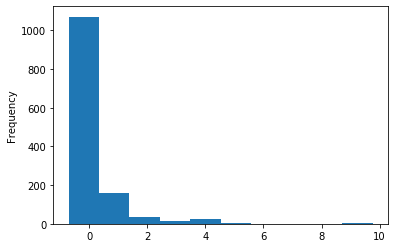

In [26]:
X["fare"].plot(kind="hist");

In [14]:
import seaborn as sns

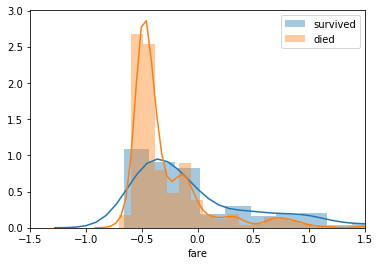

In [33]:
mask = y == 1
ax = sns.distplot(X[mask]['fare'], label="survived")
ax = sns.distplot(X[~mask]['fare'], label="died")
ax.set_xlim(-1.5, 1.5)
ax.legend();

## Scatter

A scatter plot show the relationship between two numeric columns:

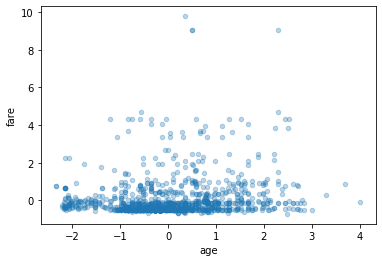

In [35]:
X.plot(kind="scatter", x="age",y="fare", alpha=.3);

There doesn't seem to be much correlation between these two features. The Pearson correlation between the two:

In [36]:
X['age'].corr(X['fare'])

0.17755958432531976

## Jointplot

A fancy scatter plot. Shows histograms and density plots for each variable as well as a regression line. 

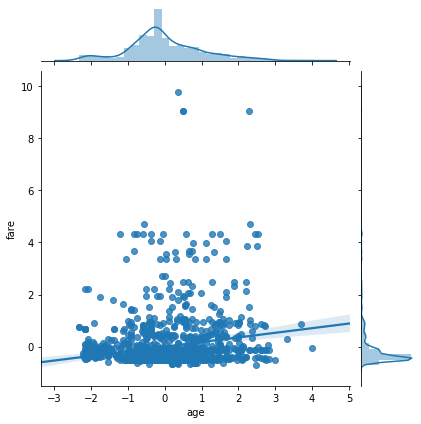

In [40]:
sns.jointplot("age","fare",data=X, kind='reg');

## Pair Grid

Pair grid is a plot matrix of columns and Kernel Density estimations. 

To color by a column, use need to use the `hue` parameter. By coloring with the target, we can see if eatures have different effects on the target.

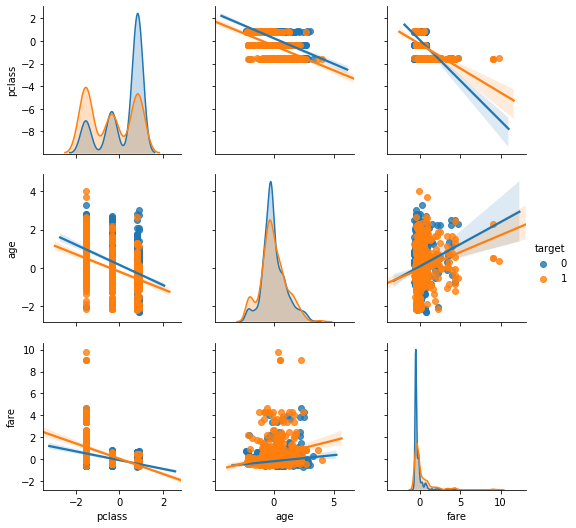

In [50]:
cols = ["pclass", "age","fare"]
new_df = X.copy()
new_df['target'] = y
sns.pairplot(new_df, vars=cols, hue="target",kind="reg");

## Box and Violin Plots

Box and violin plots visualize distributions. These plots can visualize a feature against a target:

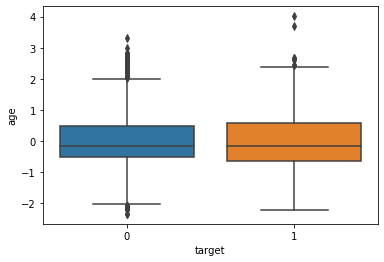

In [52]:
sns.boxplot("target", "age", data=new_df);

Violin plots help with distribution visualizations:

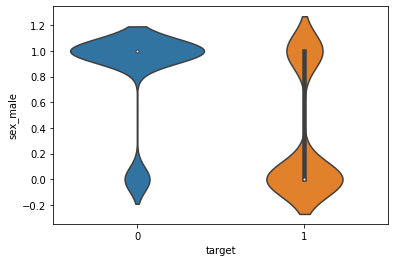

In [54]:
sns.violinplot("target", "sex_male", data=new_df);

## Correlation

We can use pairwise comparison between features. The plot shows Pearson correlation:

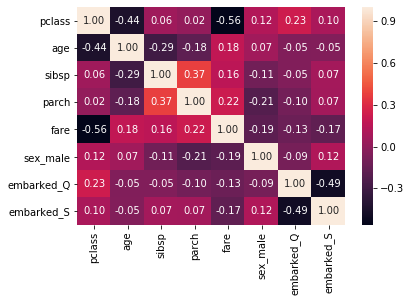

In [62]:
sns.heatmap(X.corr(), fmt=".2f", annot=True);

Highly correlated columns don't add value and can throw off feature importance and interpretation of regression coefficients. 

Below we create a function to find correlated columns. In our current dataset there are no highly correlated features. 

If we had correlated columns, we could choose to remove either the columns from level_0 or level_1 from the feature dataset. The function below allows us to find highly correlated features.

In [7]:
def correlated_columns(df, threshold=0.95):
    return (
        df.corr()
        .pipe(
            lambda df1:pd.DataFrame(np.tril(df1, k=-1),
                                     columns=df.columns,
                                     index=df.columns,
        )
    )
        .stack()
        .rename("pearson")
        .pipe(
            lambda s: s[s.abs() > threshold].reset_index()
        
        )
        .query("level_0 not in level_1")
    
    )

In [8]:
correlated_columns(X) # returns empty dataframe

,level_0,level_1,pearson


## Rad Viz

RadViz plots show each sample on a circle, with the feautres on the circumference. The values are normalized, and you can imagine that each figure has a spring that pulls samples to it based on the value.

This helps visualize seperability between targets.

In [69]:
from pandas.plotting import radviz

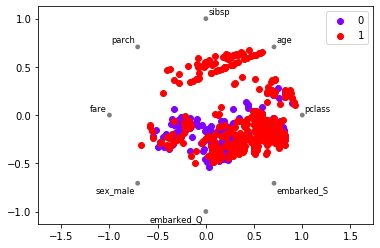

In [79]:
radviz(new_df, "target", colormap="rainbow");

## Parallel Coordinates

For multivariate data, ou can use a parallel coordinate plots to see clustering visually.

In [80]:
from pandas.plotting import parallel_coordinates

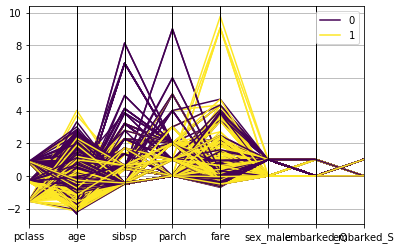

In [83]:
parallel_coordinates(new_df, "target", colormap="viridis");